# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from dissipationtheory.constants import ureg, qe, epsilon0

In [3]:
from dissipationtheory.dissipation8a import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation8b import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation8b import integrand1jit, integrand2jit, K_jit
from dissipationtheory.dissipation8b import gamma_perpendicular_jit, freq_perpendicular_jit 

In [97]:
THIS = 'dissipation-theory--Study-45--'
figs = {}

# Cantilever and sample

In [4]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degrees'),
    L = ureg.Quantity(1000, 'nm'), 
    d = ureg.Quantity(38, 'nm'),
)

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary the conductivity $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Pick a starting $\sigma$ and compute the associated charge density that achieves the above target mobility.

In [5]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

In [6]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'),                  # 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''), # ? change from 20 to 100
    sigma = sigma,
    rho = rho,
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

In [7]:
sample1_jit = SampleModel1Jit(**sample1.args())

# Trial dissipation calculation

In [8]:
gamma_perpendicular_jit(integrand1jit, sample1_jit, np.array([0., 0., 73e-9]))

<Quantity(0.6770331096580011, 'piconewton * second / meter')>

# Trial frequency shift calculation

In [13]:
result = freq_perpendicular_jit(integrand1jit, sample1_jit, np.array([0., 0., 73e-9]))
result

Magnitude,[-2.181251447438716 0.012647751192719752]
Units,hertz


In [14]:
result.sum()

<Quantity(-2.168603696245996, 'hertz')>

# Loop over conductivities

In [18]:
N_sigma = 100 # 20 to 200

In [19]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Compute a corresponding charge density array.

In [20]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

We now have an array of conductivities and charge densities.

A helper function.

In [21]:
def latex_float(f):
    """Example function call.

        latex_float(3e-7)
        => '$3.0 \\times 10^{-7}$'
        
    """
    float_str = "{0:.1e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str    

A data class, adapted from `dissipationtheory7.py`.

In [91]:
class ExptSweepConductivity(object):

    def __init__(self, msg):

        self.msg = msg
        self.df = pd.DataFrame()
        
    def calculate(self, integrand, sample, location, sigma, rho):
        """Create a pandas dataframe row of useful results."""

        for sigma_, rho_ in zip(sigma, rho):
            
            sample.rho = rho_.to('1/m^3').magnitude
            sample.sigma = sigma_.to('S/m').magnitude
        
            gamma = gamma_perpendicular_jit(integrand, sample, location)
            freq = freq_perpendicular_jit(integrand, sample, location)
            
            ep = sample.epsilon_s.real   
            z_c = ureg.Quantity(location[2], 'm')
            LD = ureg.Quantity(1/sample.kD, 'm')
            rho = ureg.Quantity(sample.rho, '1/m^3')
            omega_0 = (ureg.Quantity(sample.sigma, 'S/m')/epsilon0).to('Hz')
            omega_c = ureg.Quantity(sample.cantilever.omega_c, 'Hz')
            
            new_row = pd.DataFrame([
                {'sigma [S/m]': sigma_.to('S/m').magnitude,
                'rho [1/cm^3]': rho_.to('1/cm^3').magnitude,
                'L_D [nm]': LD.to('nm').magnitude,
                'rho scaled 1': (z_c**2/(LD**2)).to('').magnitude,
                'rho scaled 2': (z_c**2/(ep * LD**2)).to('').magnitude,
                'rho scaled 3': (z_c**2/(7.742 * ep * LD**2)).to('').magnitude,  # see below
                'omega0 [Hz]': omega_0.to('Hz').magnitude,
                'omega_c [Hz]': omega_c.to('Hz').magnitude,
                'omega_c scaled': (omega_0/(ep * omega_c)).to('').magnitude,
                'gamma [pN s/m]': gamma.to('pN s/m').magnitude,
                'frequency [Hz]': freq.to('Hz').magnitude}])
        
            self.df = pd.concat([self.df, new_row], ignore_index=True)
    
    def plot_friction(self):
        
        y = self.df['gamma [pN s/m]'].values
        x1 = self.df['omega_c scaled'].values
        x2 = self.df['rho [1/cm^3]'].values
        
        # Define functions to convert from  $\hat{\rho}$ to $\rho$ and back again
    
        c = (x2/x1)[0]
        fwd = lambda x1: x1*c
        rev = lambda x2: x2/c 

        with plt.style.context('seaborn-v0_8'):
        
            fig, ax1 = plt.subplots(1, 1, figsize=(3.50, 3.00))
            
            ax1.semilogx(x1, y)
            ax1.set_ylabel((r'friction $\gamma_{\perp}$ [pN s/m]'))
            ax1.set_xlabel(r'scaled frequency $\Omega_0 = '
                           r'\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
                    
            ax2 = ax1.secondary_xaxis("top", functions=(fwd,rev))
            ax2.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
            plt.tight_layout()
            
        return fig
        
    def plot_frequency(self, abs=False):
        
        y1 = np.array([x[0] for x in self.df['frequency [Hz]'].values])
        y2 = np.array([x[1] for x in self.df['frequency [Hz]'].values])
        if abs:
            y1 = np.abs(y1)
            y2 = np.abs(y2)

        x1 = self.df['rho scaled 3'].values
        x2 = self.df['rho [1/cm^3]'].values
        
        # Define functions to convert from  $\hat{\rho}$ to $\rho$ and back again
    
        c = (x2/x1)[0]
        fwd = lambda x1: x1*c
        rev = lambda x2: x2/c 

        with plt.style.context('seaborn-v0_8'):
        
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.50, 3.00))
            
            ax1.semilogx(x1, y1, label='static')
            ax2.semilogx(x1, y2, label='dynamic')
            
            if abs:
                ax1.set_ylabel(r'$|\Delta f_{\mathrm{stat}}|$ [Hz]')
                ax2.set_ylabel(r'$|\Delta f_{\mathrm{dyn}}|$ [Hz]')
            else:
                ax1.set_ylabel(r'$\Delta f_{\mathrm{stat}}$ [Hz]')
                ax2.set_ylabel(r'$\Delta f_{\mathrm{dyn}}$ [Hz]')

            xlabel_tex = r'$\hat{\rho}_3 = ' \
                         r'z^2_{\mathrm{c}} \Big/ ' \
                         r'7.742 \, \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$'

            xlabel_plain = r'$\hat{\rho}_3 = ' \
                           r'z^2_{\mathrm{c}} \: / \: ' \
                           r'7.742 \, \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$'
            
            if plt.rcParams['text.usetex']:
                ax1.set_xlabel(xlabel_tex)
                ax2.set_xlabel(xlabel_tex)
            else:
                ax1.set_xlabel(xlabel_plain)
                ax2.set_xlabel(xlabel_plain)
                    
            ax1top = ax1.secondary_xaxis("top", functions=(fwd,rev))
            ax1top.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')

            ax2top = ax2.secondary_xaxis("top", functions=(fwd,rev))
            ax2top.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
            
            plt.tight_layout()
            
        return fig

Run the simulation

In [98]:
expt = {}
expt['01'] = ExptSweepConductivity('perovskite-like sample')
expt['01'].calculate(integrand1jit, sample1_jit, np.array([0., 0., 73e-9]), sigma__array, rho__array)

Plot the results.

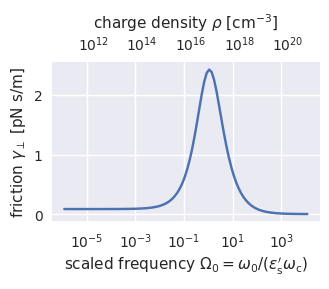

In [99]:
figs['01'] = expt['01'].plot_friction()
figs['01']

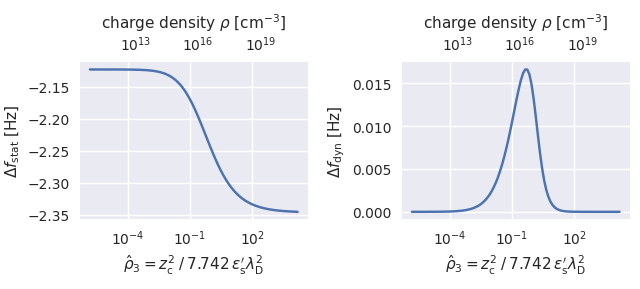

In [100]:
figs['02'] = expt['01'].plot_frequency()
figs['02']

# Save the figures

In [101]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-45.ipynb && open dissipation-theory--Study-45.html

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-45.ipynb`
- Continued from: `dissipation-theory--Study-34.ipynb`
- Continued to: ---

:::